# Segmenting and Clustering Neighborhoods in Toronto

## Table of Contents

1. [Download and Explore Dataset](#item1)
1. [Get Geo information](#item2)
1. [Explore and cluster the neighborhoods in Toronto](#item3)
1. [Analyze each Neighbourhood](#item4)
1. [Cluster Neighborhoods](#item5)

## Preparations

In [3]:
!conda install -c conda-forge geopy folium=0.5.0 --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forg

In [47]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from geopy.geocoders import Nominatim

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt # plotting library
%matplotlib inline 

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
import folium

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## 1. Download and Explore Dataset

Download HTML to local file and use Pandas to find tables in it. Then leave only columns we are interested in with filled in Borough.

In [5]:
!wget -q -O 'List_of_postal_codes_of_Canada.html' https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
print('Data downloaded!')

Data downloaded!


In [6]:
df_list = pd.read_html('List_of_postal_codes_of_Canada.html', header=0, na_values='Not assigned') # read data
df = pd.concat(df_list, sort=False)[['Postcode', 'Borough', 'Neighbourhood']] # clear garbage
df = df[df['Borough'].notna()] # clear "Not assigned" Boroughs
df.rename(columns={"Postcode": "PostalCode"}, inplace=True)
df.head()

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


In [7]:
df.shape

(210, 3)

In [8]:
df.describe()

,PostalCode,Borough,Neighbourhood
count,210,210,210
unique,103,10,208
top,M8Y,Etobicoke,Runnymede
freq,8,45,2


There are 210 rows, but only 103 unique Postal Codes. Let's concatenate Neighbourhoods by Postal Code and Borough.

In [9]:
df_grouped = df.groupby(['PostalCode', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()
df_grouped.head()

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [10]:
df_grouped.describe()

,PostalCode,Borough,Neighbourhood
count,103,103,103
unique,103,10,103
top,M9W,North York,"Cloverdale, Islington, Martin Grove, Princess ..."
freq,1,24,1


In [74]:
df_grouped.shape

(103, 3)

Now there are no postal code duplicates.

<a id='item2'></a>

## 2. Get Geo information

In [11]:
!wget -q -O 'Geospatial_data.csv' http://cocl.us/Geospatial_data

In [12]:
geo_df = pd.read_csv('Geospatial_data.csv')
geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [13]:
geo_df.set_index('Postal Code', inplace=True)
geo_df.head()

,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


In [14]:
geo_coordinates = pd.DataFrame(columns=['PostalCode', 'Latitude', 'Longitude'])
for postal_code in df_grouped['PostalCode']:
    latitude = geo_df.loc[postal_code, 'Latitude']
    longitude = geo_df.loc[postal_code, 'Longitude']
    geo_coordinates = geo_coordinates.append({'PostalCode': postal_code, 'Latitude': latitude, 'Longitude': longitude}, ignore_index=True)

neighborhoods = df_grouped
neighborhoods = neighborhoods.join(geo_coordinates.set_index('PostalCode'), on='PostalCode')
neighborhoods.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [15]:
neighborhoods.shape

(103, 5)

<a id='item3'></a>

## 3. Explore and cluster the neighborhoods in Toronto

Get coordinates of Toronto.

In [16]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude1 = location.latitude
longitude1 = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude1, longitude1))

The geograpical coordinate of Toronto City are 43.653963, -79.387207.


Create a map of Toronto with neighborhoods superimposed on top.

In [17]:
map_toronto = folium.Map(location=[latitude1, longitude1], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood, postal_code in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighbourhood'], neighborhoods['PostalCode']):
    label = '{}, {} ({})'.format(neighborhood, borough, postal_code)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

![map1.jpg](https://raw.githubusercontent.com/OlegCRS/Coursera_Capstone/master/map1.jpg)

Link: https://raw.githubusercontent.com/OlegCRS/Coursera_Capstone/master/map1.jpg

Let's simplify the above map and segment and cluster only the boroughs containing word "Toronto". So let's slice the original dataframe and create a new dataframe with filtered data.

In [18]:
filtered = neighborhoods[neighborhoods['Borough'].str.contains('Toronto')].reset_index(drop=True)
filtered.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [19]:
filtered.shape

(39, 5)

Let's get the geographical coordinates of Downtown Toronto.

In [20]:
address = 'Downtown Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude2 = location.latitude
longitude2 = location.longitude
print('The geograpical coordinate of Downtown Toronto are {}, {}.'.format(latitude2, longitude2))

The geograpical coordinate of Downtown Toronto are 43.6541737, -79.38081164513409.


In [99]:
map_toronto_new = folium.Map(location=[latitude2, longitude2], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood, postal_code in zip(filtered['Latitude'], filtered['Longitude'], filtered['Borough'], filtered['Neighbourhood'], filtered['PostalCode']):
    label = '{}, {} ({})'.format(neighborhood, borough, postal_code)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_new)  
    
map_toronto_new

![map2.jpg](https://raw.githubusercontent.com/OlegCRS/Coursera_Capstone/master/map2.jpg)

Link: https://raw.githubusercontent.com/OlegCRS/Coursera_Capstone/master/map2.jpg

Configure credentials and hide them from publicity

In [22]:
# The code was removed by Watson Studio for sharing.

Let's borrow the **get_category_type** function from the Foursquare lab.

In [23]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Let's create a function to repeat the same process to all the postal codes in filtered Toronto boroughs.

In [24]:
def getNearbyVenues(codes, boroughs, neighborhoods, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for code, borough, neighborhood, lat, lng in zip(codes, boroughs, neighborhoods, latitudes, longitudes):
        print(code)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            code,
            borough,
            neighborhood, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode',
                  'Borough',
                  'Neighbourhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
LIMIT = 100

toronto_venues = getNearbyVenues(
    codes=filtered['PostalCode'],
    boroughs=filtered['Borough'],
    neighborhoods=filtered['Neighbourhood'],
    latitudes=filtered['Latitude'],
    longitudes=filtered['Longitude']
)

M4E
M4K
M4L
M4M
M4N
M4P
M4R
M4S
M4T
M4V
M4W
M4X
M4Y
M5A
M5B
M5C
M5E
M5G
M5H
M5J
M5K
M5L
M5N
M5P
M5R
M5S
M5T
M5V
M5W
M5X
M6G
M6H
M6J
M6K
M6P
M6R
M6S
M7A
M7Y


In [26]:
print(toronto_venues.shape)
toronto_venues.head()

(1711, 9)


,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,M4E,East Toronto,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,M4E,East Toronto,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


Let's check how many venues were returned for each postal code

In [27]:
toronto_venues.groupby('Neighbourhood').count()

,PostalCode,Borough,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100,100,100
Berczy Park,56,56,56,56,56,56,56,56
"Brockton, Exhibition Place, Parkdale Village",22,22,22,22,22,22,22,22
Business Reply Mail Processing Centre 969 Eastern,19,19,19,19,19,19,19,19
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",18,18,18,18,18,18,18,18
"Cabbagetown, St. James Town",47,47,47,47,47,47,47,47
Central Bay Street,79,79,79,79,79,79,79,79
"Chinatown, Grange Park, Kensington Market",89,89,89,89,89,89,89,89
Christie,18,18,18,18,18,18,18,18


Let's find out how many unique categories can be curated from all the returned venues

In [28]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 236 uniques categories.


<a id="item4"></a>

## 4. Analyze each Neighbourhood

In [29]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot.insert(0, "Neighbourhood", toronto_venues['Neighbourhood'], True)

toronto_onehot.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [30]:
toronto_onehot.shape

(1711, 237)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [31]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.00,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.030000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.01,0.020000,0.000000,0.000000,0.01,0.010000,0.010000,0.00,0.000000,0.000000,0.040000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.070000,0.000000,0.000,0.000000,0.00,0.01,0.000000,0.000000,0.020000,0.000000,0.020000,0.00000,0.000000,0.00000

In [32]:
toronto_grouped.shape

(39, 237)

Let's print each neighborhood along with the top 5 most common venues

In [33]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
             venue  freq
0      Coffee Shop  0.07
1       Restaurant  0.05
2  Thai Restaurant  0.04
3             Café  0.04
4       Steakhouse  0.03


----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1        Cocktail Bar  0.05
2  Seafood Restaurant  0.04
3         Cheese Shop  0.04
4          Restaurant  0.04


----Brockton, Exhibition Place, Parkdale Village----
                 venue  freq
0                 Café  0.14
1       Breakfast Spot  0.09
2          Coffee Shop  0.09
3  Japanese Restaurant  0.05
4            Pet Store  0.05


----Business Reply Mail Processing Centre 969 Eastern----
                  venue  freq
0    Light Rail Station  0.11
1           Yoga Studio  0.05
2                   Spa  0.05
3  Gym / Fitness Center  0.05
4         Garden Center  0.05


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
                 venue  freq
0      Airpo

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [35]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Restaurant,Thai Restaurant,Café,Bar,Sushi Restaurant,Steakhouse,Vegetarian / Vegan Restaurant,Cosmetics Shop,Concert Hall
1,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Beer Bar,Seafood Restaurant,Bakery,Restaurant,Cheese Shop,Café,Pub
2,"Brockton, Exhibition Place, Parkdale Village",Café,Coffee Shop,Breakfast Spot,Grocery Store,Stadium,Burrito Place,Restaurant,Climbing Gym,Pet Store,Bakery
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Comic Shop,Park,Pizza Place,Recording Studio,Restaurant,Burrito Place,Brewery
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Lounge,Airport Terminal,Sculpture Garden,Bar,Coffee Shop,Rental Car Location,Boutique,Harbor / Marina,Plane


<a id="item5"></a>

## 5. Cluster Neighborhoods

We don't know optimal clusters amount so let's try "Elbow method" to find an optimum

In [54]:
toront_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

max_clusters = toront_grouped_clustering.shape[0]
wcss = []

# fit kmeans for various cluster counts 
for kclusters in range (1, max_clusters+1):
    kmeans = KMeans(n_clusters=kclusters).fit(toront_grouped_clustering)
    wcss.append(kmeans.inertia_)

In [80]:
distances = []

# calculate distances
p1 = np.array([1, wcss[0]])
p2 = np.array([max_clusters, wcss[max_clusters-1]])
for i in range(max_clusters):
    p3 = np.array([i, wcss[i]])
    d = np.linalg.norm(np.cross(p2-p1, p3-p1))/np.linalg.norm(p2-p1)
    distances.append(d)

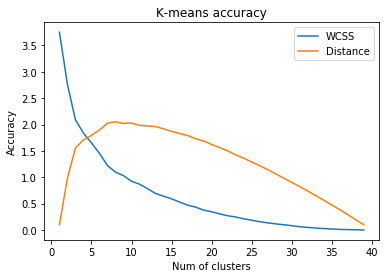

In [81]:
x = np.arange(1, max_clusters + 1)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Num of clusters')
ax.set_ylabel('Accuracy')
ax.set_title('K-means accuracy')

line1, = ax.plot(x, wcss)
line1.set_label('WCSS')

line2, = ax.plot(x, distances)
line2.set_label('Distance')

ax.legend()

There is no "Elbow" so the optimal clustering is impossible. However,let's choose the best number of clusters.

In [84]:
m = max(distances)
n_clusters = distances.index(m) + 1

print('Max distance: {}'.format(m))
print('Optimal cluster number: {}'.format(n_clusters))

Max distance: 2.052131346519201
Optimal cluster number: 8


In [85]:
kmeans = KMeans(n_clusters=n_clusters).fit(toront_grouped_clustering)
kmeans.labels_[0:10]

array([5, 5, 0, 5, 5, 5, 5, 0, 0, 5], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [86]:
clustered_neighborhoods = neighborhoods_venues_sorted
clustered_neighborhoods.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = filtered
toronto_merged = toronto_merged.join(clustered_neighborhoods.set_index('Neighbourhood'), on='Neighbourhood')
toronto_merged.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,4,Trail,Pub,Neighborhood,Health Food Store,Yoga Studio,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,5,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Yoga Studio,Frozen Yogurt Shop,Pub,Pizza Place,Lounge
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,5,Park,Movie Theater,Sandwich Place,Burrito Place,Fast Food Restaurant,Italian Restaurant,Fish & Chips Shop,Steakhouse,Ice Cream Shop,Sushi Restaurant
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Bakery,Brewery,Italian Restaurant,American Restaurant,Yoga Studio,Comfort Food Restaurant,Seafood Restaurant,Sandwich Place
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,6,Park,Lake,Bus Line,Swim School,Diner,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


In [87]:
# create map
map_clusters = folium.Map(location=[latitude2, longitude2], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, code, borough, neighborhood, cluster in zip(
    toronto_merged['Latitude'],
    toronto_merged['Longitude'],
    toronto_merged['PostalCode'],
    toronto_merged['Borough'],
    toronto_merged['Neighbourhood'],
    toronto_merged['Cluster Labels']
):
    label = '{}, {} ({}) Cluster {}'.format(neighborhood, borough, postal_code, cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

![map3.jpg](https://raw.githubusercontent.com/OlegCRS/Coursera_Capstone/master/map3.jpg)

Link: https://raw.githubusercontent.com/OlegCRS/Coursera_Capstone/master/map3.jpg

Examine clusters

In [98]:
for i in range(n_clusters):
    print('Cluyster No. %d' % i)
    display(toronto_merged.loc[toronto_merged['Cluster Labels'] == i, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]])

Cluyster No. 0


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Studio District,Café,Coffee Shop,Bakery,Brewery,Italian Restaurant,American Restaurant,Yoga Studio,Comfort Food Restaurant,Seafood Restaurant,Sandwich Place
24,"The Annex, North Midtown, Yorkville",Sandwich Place,Café,Coffee Shop,Liquor Store,Pharmacy,Pub,Middle Eastern Restaurant,BBQ Joint,History Museum,Pizza Place
25,"Harbord, University of Toronto",Café,Bar,Italian Restaurant,Japanese Restaurant,Bookstore,Restaurant,Bakery,Chinese Restaurant,Beer Bar,Beer Store
26,"Chinatown, Grange Park, Kensington Market",Bar,Vietnamese Restaurant,Café,Bakery,Coffee Shop,Chinese Restaurant,Dumpling Restaurant,Mexican Restaurant,Vegetarian / Vegan Restaurant,Grocery Store
30,Christie,Grocery Store,Café,Park,Nightclub,Coffee Shop,Diner,Baby Store,Restaurant,Athletics & Sports,Candy Store
31,"Dovercourt Village, Dufferin",Bakery,Pharmacy,Grocery Store,Music Venue,Supermarket,Bank,Brewery,Pool,Café,Middle Eastern Restaurant
32,"Little Portugal, Trinity",Bar,Coffee Shop,Restaurant,Asian Restaurant,Wine Bar,Vietnamese Restaurant,Café,Pizza Place,Bakery,Men's Store
33,"Brockton, Exhibition Place, Parkdale Village",Café,Coffee Shop,Breakfast Spot,Grocery Store,Stadium,Burrito Place,Restaurant,Climbing Gym,Pet Store,Bakery
34,"High Park, The Junction South",Mexican Restaurant,Café,Bar,Thai Restaurant,Grocery Store,Fried Chicken Joint,Park,Music Venue,Diner,Cajun / Creole Restaurant


Cluyster No. 1


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Rosedale,Park,Playground,Trail,Department Store,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


Cluyster No. 2


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Roselawn,Garden,Yoga Studio,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


Cluyster No. 3


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,"Moore Park, Summerhill East",Playground,Trail,Yoga Studio,Dessert Shop,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


Cluyster No. 4


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,The Beaches,Trail,Pub,Neighborhood,Health Food Store,Yoga Studio,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant


Cluyster No. 5


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"The Danforth West, Riverdale",Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Yoga Studio,Frozen Yogurt Shop,Pub,Pizza Place,Lounge
2,"The Beaches West, India Bazaar",Park,Movie Theater,Sandwich Place,Burrito Place,Fast Food Restaurant,Italian Restaurant,Fish & Chips Shop,Steakhouse,Ice Cream Shop,Sushi Restaurant
5,Davisville North,Park,Convenience Store,Department Store,Food & Drink Shop,Hotel,Sandwich Place,Gym,Breakfast Spot,Electronics Store,Eastern European Restaurant
6,North Toronto West,Clothing Store,Coffee Shop,Sporting Goods Shop,Gym / Fitness Center,Fast Food Restaurant,Diner,Mexican Restaurant,Dessert Shop,Park,Chinese Restaurant
7,Davisville,Sandwich Place,Dessert Shop,Pizza Place,Coffee Shop,Italian Restaurant,Café,Gym,Sushi Restaurant,Greek Restaurant,Brewery
9,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",Coffee Shop,Pub,Supermarket,Liquor Store,Sushi Restaurant,Vietnamese Restaurant,Pizza Place,American Restaurant,Light Rail Station,Restaurant
11,"Cabbagetown, St. James Town",Coffee Shop,Italian Restaurant,Pub,Park,Pizza Place,Chinese Restaurant,Bakery,Restaurant,Café,Indian Restaurant
12,Church and Wellesley,Coffee Shop,Japanese Restaurant,Restaurant,Sushi Restaurant,Gay Bar,Café,Fast Food Restaurant,Hotel,Mediterranean Restaurant,Gastropub
13,Harbourfront,Coffee Shop,Park,Pub,Café,Bakery,Mexican Restaurant,Breakfast Spot,Theater,Distribution Center,Performing Arts Venue
14,"Ryerson, Garden District",Coffee Shop,Clothing Store,Café,Japanese Restaurant,Middle Eastern Restaurant,Cosmetics Shop,Theater,Ramen Restaurant,Bookstore,Diner


Cluyster No. 6


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Lawrence Park,Park,Lake,Bus Line,Swim School,Diner,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


Cluyster No. 7


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,"Forest Hill North, Forest Hill West",Park,Jewelry Store,Trail,Sushi Restaurant,Dim Sum Restaurant,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
